In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models, callbacks, metrics
import os

tf.get_logger().setLevel('INFO')
tf.__version__

'2.9.2'

In [ ]:
# Check if GPU is available
if len(tf.config.list_physical_devices('GPU')) != 0:
    print(f"GPU available: {tf.test.gpu_device_name()}")
else:
    print("GPU unavailable")

GPU unavailable


In [ ]:
# Load dataset
train_dir = "/content/drive/MyDrive/melanoma_study/train" 
val_dir = "/content/drive/MyDrive/melanoma_study/valid" 
test_dir = "/content/drive/MyDrive/melanoma_study/test"
train_dir ,val_dir, test_dir

('/content/drive/MyDrive/melanoma_study/train',
 '/content/drive/MyDrive/melanoma_study/valid',
 '/content/drive/MyDrive/melanoma_study/test')

In [ ]:
# Set random seed to ensure reproducibility
tf.keras.utils.set_random_seed(42)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
 batch_size=32,image_size=(256,256), seed=42)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
 batch_size=32,image_size=(256,256),seed=42)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
batch_size=32,image_size=(256,256),shuffle=False)

Found 4468 files belonging to 2 classes.
Found 1116 files belonging to 2 classes.
Found 10982 files belonging to 1 classes.


In [ ]:
class_names = train_ds.class_names
class_names

['benign', 'malignant']

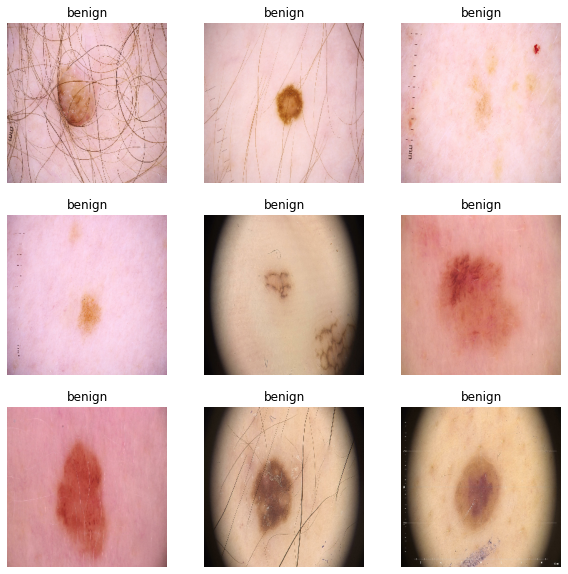

In [ ]:
# Visualize training images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Set class weights
n_b = len(os.listdir('/content/drive/MyDrive/melanoma_study/train/benign'))
n_m = len(os.listdir('/content/drive/MyDrive/melanoma_study/train/malignant'))

w_b = (n_b+n_m)/(2*n_b)
w_m = (n_b+n_m)/(2*n_m)

class_weights = {0:w_b, 1:w_m}
w_b, w_m

(0.5585, 4.773504273504273)

In [ ]:
# Use base model from Xception
input_shape=(256,256,3)

base_model = tf.keras.applications.Xception(include_top=False, 
                                               weights='imagenet',
                                               input_shape=input_shape,
                                               pooling='max')

# Make base model untrainable
base_model.trainable = False

# Build complete model
model0 = models.Sequential([
    keras.Input(shape=input_shape),
    layers.Rescaling(scale=1./255),
    base_model,
    layers.Dense(units = 1024, activation='relu'),
    layers.Dense(units = 32, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.Dense(units = 1, activation='sigmoid')
])

model0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 32)                32800     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22,992,489
Trainable params: 2,131,009
N

In [ ]:
model0.compile(optimizer='Adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy',
                         tf.keras.metrics.Precision(), 
                         tf.keras.metrics.Recall(),
                         tf.keras.metrics.AUC()])

In [ ]:
#Create early stopping call back
early_stopping = callbacks.EarlyStopping(patience=10, monitor='val_loss')

In [ ]:
# Fit model
history = model0.fit(train_ds, 
            epochs=50,
            validation_data=valid_ds,
            callbacks=[early_stopping],
            class_weight=class_weights)

Epoch 1/50
140/140 [==============================] - 217s 1s/step - loss: 0.7824 - accuracy: 0.3724 - precision_1: 0.1218 - recall_1: 0.8034 - auc_1: 0.6133 - val_loss: 0.7293 - val_accuracy: 0.3737 - val_precision_1: 0.1388 - val_recall_1: 0.9655 - val_auc_1: 0.8002
Epoch 2/50
140/140 [==============================] - 213s 1s/step - loss: 0.6361 - accuracy: 0.6761 - precision_1: 0.1980 - recall_1: 0.6859 - auc_1: 0.7235 - val_loss: 0.7173 - val_accuracy: 0.7464 - val_precision_1: 0.2477 - val_recall_1: 0.7069 - val_auc_1: 0.7783
Epoch 3/50
140/140 [==============================] - 211s 1s/step - loss: 0.6117 - accuracy: 0.7422 - precision_1: 0.2429 - recall_1: 0.6902 - auc_1: 0.7517 - val_loss: 0.7194 - val_accuracy: 0.7366 - val_precision_1: 0.2443 - val_recall_1: 0.7328 - val_auc_1: 0.7974
Epoch 4/50
140/140 [==============================] - 210s 1s/step - loss: 0.5768 - accuracy: 0.8039 - precision_1: 0.2910 - recall_1: 0.6068 - auc_1: 0.7635 - val_loss: 0.4053 - val_accuracy: 

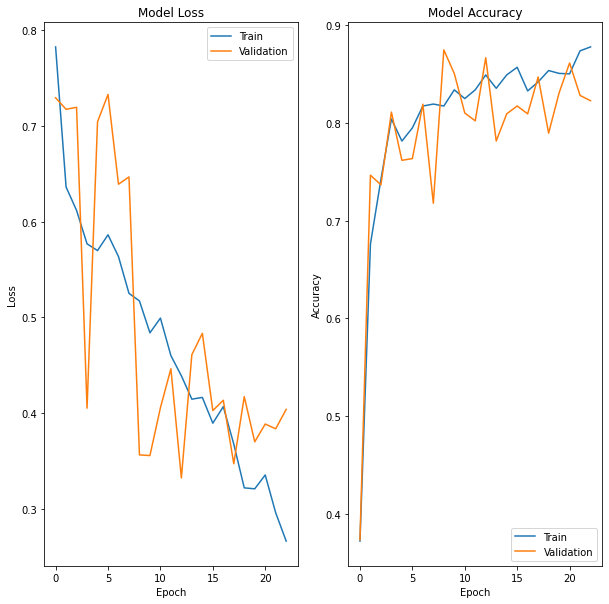

In [ ]:
# Plot of loss and accuracy of training set and validation set
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='Training accuracy')
plt.plot(history.history['val_accuracy'],label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.show()

In [ ]:
# Model prediction
pred_prob = model0.predict(test_ds)

def class_label(x):
  if x>=0.5:
    return 1
  else:
    return 0

pred_label = np.array(list(map(class_label, pred_prob)))

344/344 [==============================] - 3436s 10s/step


In [ ]:
model0.metrics_names

['loss', 'accuracy', 'precision_1', 'recall_1']

In [ ]:
loss, accuracy, precision, recall = model0.evaluate(valid_ds)
f1_score = 2*precision*recall/(precision+recall)

print(f"Model loss: {loss}")
print(f"Model accuracy: {accuracy*100: .2f}")
print(f"Model F1 score: {f1_score}")

35/35 [==============================] - 39s 880ms/step - loss: 0.5397 - accuracy: 0.7509 - precision_1: 0.2500 - recall_1: 0.6983
Model loss: 0.5397411584854126
Model accuracy:  75.09
Model F1 score: 0.3681818184675264


In [ ]:
# Save Model
model_dir = '/content/drive/MyDrive/melanoma_study/scar_model1'
model0.save(model_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/melanoma_study/scar_model1/assets


In [ ]:
# Convert model to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/melanoma_study/scar_model1.tflite', 'wb') as f:
  f.write(tflite_model)